In [29]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn import ensemble
import pandas as pd
import numpy as np
import datetime
#coding:utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

dtfmt = '%Y-%m-%d %H:%M:%S' 
import timeit
import time
import itertools
import datetime
import lightgbm as lgbm
import math

In [85]:
def gen_fea(user_fn, click_fn, order_fn, loan_fn , loan_sum_fn):
    # step 0. INIT raw data
    user_df = pd.read_csv(user_fn)[['uid', 'active_date']]
    clk_df = pd.read_csv(click_fn) # uid, click_time, pid, param
    ord_df = pd.read_csv(order_fn)
    loan_df = pd.read_csv(loan_fn)
    loan_sum_fn = pd.read_csv(loan_sum_fn)

    #step 1 . convert load data to real data space     
    loan_df = transform(loan_df , 'loan_amount')
    loan_sum_df = transform(loan_sum_fn , 'loan_sum')
    
    #step 2 . add loan month , dt 
    loan_df['month'] = loan_df.loan_time.apply(lambda x : x[5:7]).astype('int')
    
    #step 3. user per month
    poi_set = list(set(user_df.uid))
    months = [8 , 9 ,10 , 11]
    poi_month = []
    import itertools
    for x in itertools.product(poi_set , months):
        poi_month.append(x)
    poi_per_month_df = pd.DataFrame(poi_month , columns=['uid','month'])
    
    #step 4. user loan agg info, mean,max,median,

    func_names = ['sum','mean','std', 'min' ,'max' ,'median' ]
    column_names = [ 'real_loan_amount_' + t for t in func_names]
    user_agg_df = loan_df.groupby(['uid']).agg({"real_loan_amount":[np.sum , np.mean , np.std , np.min , np.max , np.median ]})['real_loan_amount']    
    user_agg_df.columns = column_names
    user_agg_df = user_agg_df.reset_index() # add uid to column
    
    #step 5. user month loan sum 
   
    column_names = [ 'real_loan_amount_month_' + t for t in func_names]
    user_month_sum_df = loan_df.groupby(['uid','month']).agg({"real_loan_amount": np.sum }).reset_index()
    
    #setp 6. user month loan sum agg info. mean,max,....
    user_month_agg_df = user_month_sum_df.groupby(['uid']).agg({"real_loan_amount":[np.sum , np.mean , np.std , np.min , np.max , np.median ]})['real_loan_amount']
    user_month_agg_df.columns = column_names
    user_month_agg_df = user_month_agg_df.reset_index()
    
    #step 7. user month loan sum 
    
    flatten_user_month_sum_df = pd.merge( poi_per_month_df , user_month_sum_df , on=['uid' , 'month'] , how='left').fillna(0)
    flatten_user_month_sum_df = flatten_user_month_sum_df.set_index(['uid','month'])['real_loan_amount'].unstack().reset_index()
    flatten_user_month_sum_df.columns = [ 'uid','aug','sep','oct','nov']
    
    
    #step 8. feature agg 
    
    user_loan_feature_df = pd.merge(flatten_user_month_sum_df , user_agg_df , on=['uid'] , how='left' ).fillna(0)
    user_loan_feature_df = pd.merge(user_loan_feature_df , user_month_agg_df , on=['uid'] , how='left').fillna(0)
    user_loan_feature_df = pd.merge(user_loan_feature_df , loan_sum_df , on=['uid'] , how='left').fillna(0)
    
    #step 9. save file 
    user_loan_feature_df.to_csv('../')
    return user_loan_feature_df

def transform(data , column_name):
    #loan.loan_amount.apply(lambda x :math.log(x+1 , 5))
    new_column_name = "real_" + column_name
    new_column = data[column_name].apply(lambda x :5**x - 1)
    data[new_column_name] = new_column
    return data 

In [208]:

st = datetime.datetime.now()
user_fn = '../../../raw_data/t_user.csv'
click_fn = '../../../raw_data/t_click.csv'
order_fn = '../../../raw_data/t_order.csv'
loan_fn = '../../../raw_data/t_loan.csv'
loan_sum_fn = '../../../raw_data/t_loan_sum.csv'

train_data = gen_fea(user_fn, click_fn, order_fn, loan_fn , loan_sum_fn)
et = datetime.datetime.now()
print 'time cost : ' + str(et - st)

time cost : 0:00:15.751440


In [94]:
import pandas as p

In [209]:
drop_list = ['uid' , 'nov' , 'real_loan_sum' , 'month','loan_sum']
train_feature_names = np.setdiff1d(feature.columns , drop_list)
target = ['real_loan_sum']

drop_list = ['uid' , 'aug' , 'real_loan_sum' , 'month','loan_sum']
test_feature_names = np.setdiff1d(feature.columns , drop_list)


In [216]:
y_train = (feature[train_feature_names].values)[: , 0]
y_test = (feature[train_feature_names].values)[:,0]
X_train = feature[train_feature_names].values
X_test = feature[train_feature_names].values

X_predict= feature[test_feature_names].values
# create dataset for lightgbm
lgb_train = lgbm.Dataset(X_train, y_train)
lgb_eval = lgbm.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'task': 'train',
    'boosting_type': 'rf',
    'max_depth':5 , 
    'num_leaves': 63,
    'num_trees': 500,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

gbm = lgbm.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval
               )


In [217]:
 pd.DataFrame(zip(feature_names, gbm.feature_importance(importance_type='split', iteration=-1))  , columns=['featuren','importance']).sort_values(['importance'] , ascending=False)

,featuren,importance
0,aug,12933
1,oct,488
11,real_loan_amount_month_sum,462
14,sep,258
6,real_loan_amount_month_max,207
9,real_loan_amount_month_min,102
10,real_loan_amount_month_std,64
2,real_loan_amount_max,55
13,real_loan_amount_sum,37
5,real_loan_amount_min,19


In [191]:
#train rmse
res = pd.DataFrame( zip(gbm.predict(X_train) , y_train) , columns=['predict_real','gt_real']  )
res['predict_trans'] = res.predict_real.apply(lambda x : math.log(x +1 , 5))
res['gt_trans'] = res.gt_real.apply(lambda x : math.log(x +1 , 5))
res['uid'] = feature.uid
mean_squared_error(res.gt_trans , res.predict_trans)

3.3298908095725532

In [218]:
#submmision
res = pd.DataFrame( (gbm.predict(X_predict) ) , columns=['predict_real']  )
res['predict_trans'] = res.predict_real.apply(lambda x : math.log(x +1 , 5))

res['uid'] = feature.uid
res[['uid','predict_trans']].to_csv('../model/20171129.csv',index=False, header=False,)

In [173]:
from sklearn.metrics import mean_squared_error, r2_score

In [196]:
res.columns

Index([u'predict_real', u'predict_trans', u'uid'], dtype='object')

In [193]:
len(set(res.predict_trans))

46

(array([ 54816.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  36177.]),
 array([ 0.47600161,  0.71515501,  0.95430841,  1.19346181,  1.43261521,
         1.67176861,  1.91092201,  2.15007541,  2.38922881,  2.6283822 ,
         2.8675356 ]),
 <a list of 10 Patch objects>)

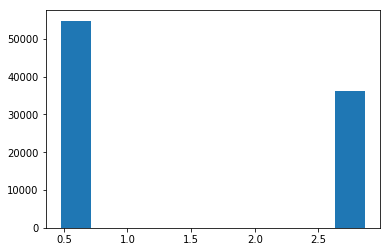

In [194]:
plt.hist(res.predict_trans)

In [204]:
def cal_corre(train):
    sns.set(style="white")


    # Compute the correlation matrix
    corr = train.corr()


    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()
